In [5]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
nlp = spacy.load("en_core_web_sm")
model = SentenceTransformer('all-MiniLM-L6-v2')

/home/poloniki/.pyenv/versions/3.8.12/envs/quint/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-09-05 11:18:22.770917: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-05 11:18:22.774862: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-05 11:18:22.774874: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-05 11:18:23.791063: W tensor

In [1]:
#with open('../quint/data/sample_texts/joe_rogan_tr.txt') as f:
with open('../quint/data/results/Short.txt') as f:
    doc = f.readlines()
    
doc = doc[0].replace("?", ". ")* 10
sentences = doc.split('. ') 

6820

In [59]:
df = pd.DataFrame()
df['sentence'] = sentences[:-1]
df['len'] = df['sentence'].apply(lambda x: len(x))
df['cum'] = df['len'].cumsum()

In [60]:
embeddings = model.encode(sentences)
A_sparse = sparse.csr_matrix(embeddings)
similarities = cosine_similarity(A_sparse)

In [61]:
best_sentences = []
steps = range(0, df.cum.max() + 4000, 8000)
for each in range(len(steps)-1):
    temp_df = df.loc[(df.cum > steps[each])&(df.cum < steps[each+1])]
    indexes = temp_df.index
    A =  embeddings[indexes[0]:indexes[-1]+1]
    A_sparse = sparse.csr_matrix(A)
    similarities = cosine_similarity(A_sparse)
    average_sim = list(np.round(similarities.mean(axis=1),2))
    min_score =np.min(average_sim)
    max_score = np.max(average_sim)
    best_sentence = [i for i, x in enumerate(average_sim) if (x > max_score-0.02) | (x == min_score)]
    for every in best_sentence:
        best_sentences.append(temp_df.iloc[every].sentence)
        
best_sentences = [each for each in best_sentences if len(each.split(' '))> 5]
df['highlight'] = df['sentence'].apply(lambda x: x in best_sentences)

In [62]:
embeddings = model.encode(sentences[:-1])
A_sparse = sparse.csr_matrix(embeddings)
similarities = cosine_similarity(A_sparse)
story = similarities.mean(axis=0)
df['story'] = story

<AxesSubplot:>

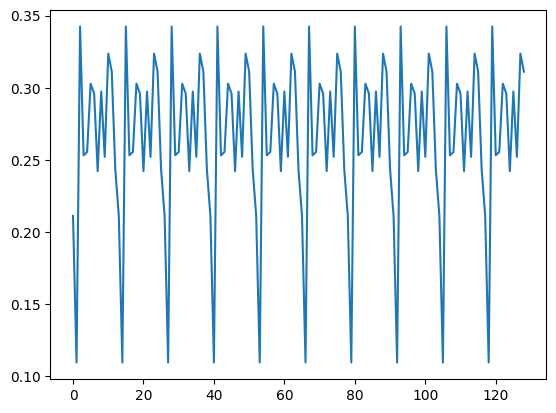

In [63]:
df['story'].plot()

<AxesSubplot:xlabel='cum', ylabel='smooth'>

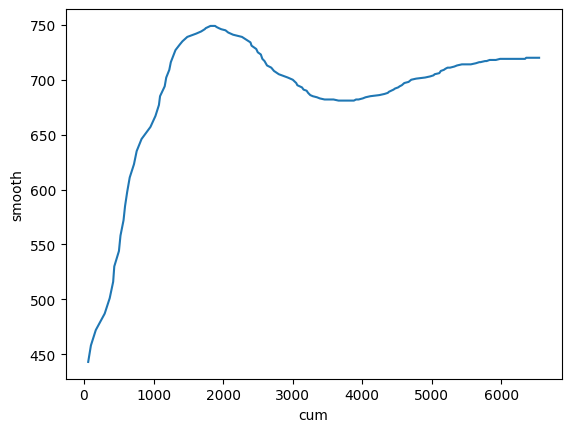

In [66]:
# Filter requirements.
import numpy as np
from scipy.signal import butter,filtfilt
import matplotlib.pyplot as plt
T = 50.0        # Sample Period
fs = 10.0       # sample rate, Hz
cutoff = 3      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 11 * fs   # Nyquist Frequency
order = 6       # 6 # 10     # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq

    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

array = butter_lowpass_filter(story,cutoff, fs, order)
df['smooth'] = array
df['smooth'] = df['smooth'].apply(lambda x: round(round(x*100,2)**2,0))
sns.lineplot(data=df, y='smooth', x='cum')
sns.lineplot(data=df.loc[(df.cum>20000)&(df.cum<20500)], y='smooth', x='cum')

<AxesSubplot:xlabel='cum', ylabel='masked'>

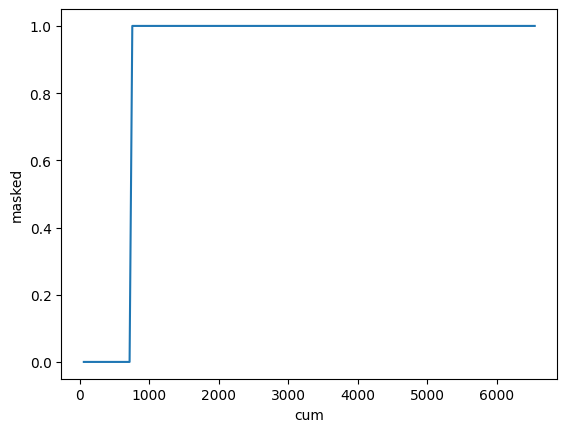

In [65]:
outlier = df['smooth'].mean() - df['smooth'].std()
df['masked'] = df['smooth'] > outlier
df['masked'] =df['masked'].astype(int)
df = df.reset_index()
sns.lineplot(data=df, y='masked', x='cum')
sns.lineplot(data=df.loc[(df.cum>20000)&(df.cum<20500)], y='masked', x='cum')

In [28]:
time_diff = df.loc[df.masked==0].copy()
time_diff['diff_cum'] = time_diff['cum'].diff().fillna(0.0)
time_diff['outliers'] = time_diff['diff_cum'].apply(lambda x: x > time_diff['diff_cum'].mean()+time_diff['diff_cum'].std(ddof=0))
total_categories = time_diff['outliers'].sum() +1

from sklearn.cluster import KMeans
X = df[['cum','masked']]
kmeans = KMeans(n_clusters=total_categories, random_state=0).fit(X)
df['label'] = kmeans.labels_ 
change_points = df.groupby('label').median()['index'] -3
true_middle_points = [min(df['index'], key=lambda x:abs(x-each)) for each in change_points]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [29]:
import string
def preprocessing(sentence):
    sentence = ''.join([each for each in sentence if each not in string.punctuation])
    return sentence

def get_persons(text):
    for doc in nlp.pipe([text]):
        mentioned = [ent.lemma_ for ent in doc.ents if ent.label_ in ['PERSON', 'PRODUCT', 'ORG', 'GPE', 'MONEY', 'CARDINAL']]
    return mentioned
    
df['names'] = df.sentence.apply(get_persons)

In [30]:
true_middle_points

[0, 4]

In [42]:
from termcolor import colored
from spacy import displacy

text = ''
for num, each in enumerate(df['sentence']):
    #Bold words
    to_bold = df['names'].iloc[num]
    if len(to_bold)>0:
        to_unpack = [i.split(' ', 1) for i in to_bold]
        flat_list = [item for sublist in to_unpack for item in sublist]
        each = " ".join(f'\033[1m{t}\033[0m' if (preprocessing(t) in flat_list) & (preprocessing(t).lower() != 'the')  else t for t in each.split())


    # Highlight best sentence if it is there 
    if df['highlight'].iloc[num] == True:
        each=colored(f'{each}. ','white','on_red')
    else:
        each=f'{each}. '
        
    if num in true_middle_points:
        text+=f' \n \n {each}'
    else:
        text+=f'{each}'
    
print(text)

 
 
 You know people are like how do you live and things like that.  They're taking money from the Russians. And of course the answer is no but I do this for a living like I speak. I don't have a YouTube channel that where it's you know, I'm Joe Rogan, but I give speeches at universities and things like that.  
 
 I do a lot of interviews and so we're recording now right on set up cool. Is it possible that you could do a YouTube channel.  Would that work.  If yeah, like I I mean if you introduce me so like I get followers. Yeah, we could do that. I'm all in that that could absolutely happen. Do you want to do that.  Is it something you want to do. 
